In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,precision_score,f1_score

**IMPORTING DATASET**

In [2]:
df=pd.read_csv("new_file.csv")

**DATA VISUALIZATION**

In [3]:
df.head()



,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 485.4+ MB


In [5]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00


In [6]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64

In [7]:
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

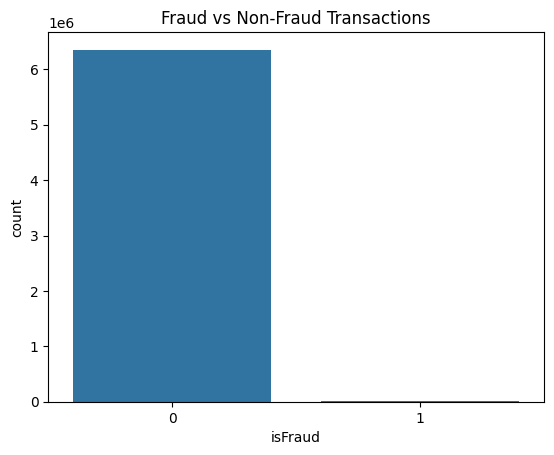

In [8]:
sns.countplot(x='isFraud',data=df)
plt.title('Fraud vs Non-Fraud Transactions')
plt.show()

<Axes: xlabel='type', ylabel='count'>

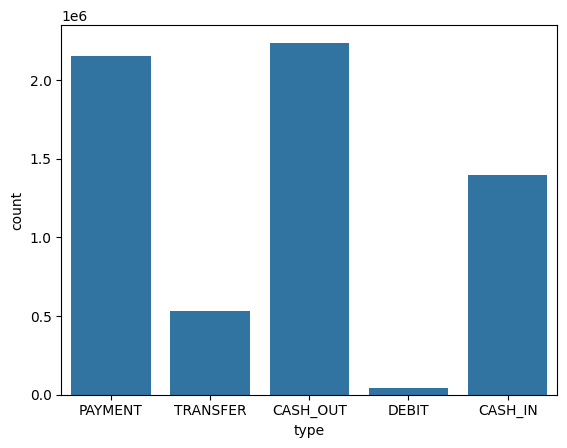

In [9]:
sns.countplot(x='type',data=df)

<Axes: xlabel='type', ylabel='amount'>

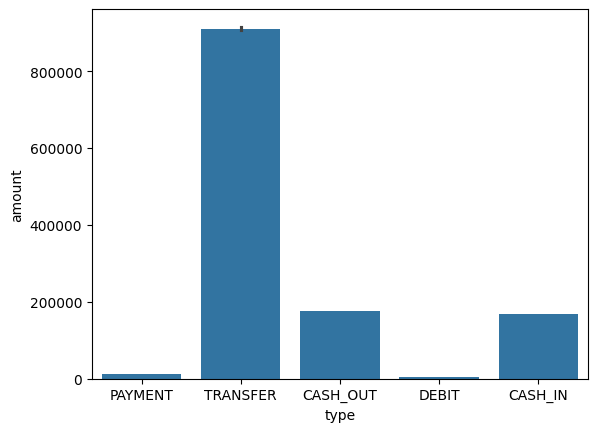

In [10]:
sns.barplot(x='type',y='amount',data=df)

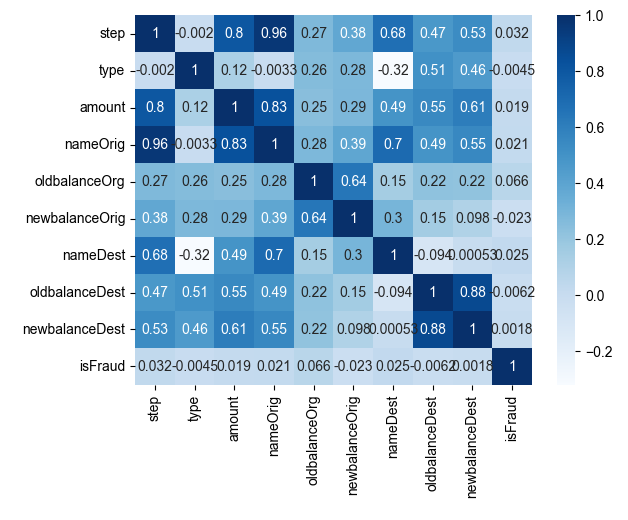

<Figure size 800x900 with 0 Axes>

In [ ]:
df_mx=df.apply(lambda x: pd.factorize(x)[0]).corr()
sns.heatmap(df_mx,annot=True,cmap='Blues')
sns.set_context='paper'
sns.set(font_scale=0.7)
plt.figure(figsize=(8,9)) 
plt.show()

Conclusions from visualisation-->
1. Transaction types like payment, cash in and cash out are used more frequently then other types.
But considering the amount involved in transaction transfer , cash in and cash out stands much higher then payment and debit.
2. In our dataset, cases of fraud are pretty rare then legitimate cases.
3. newBalanceDest and oldBalanceDest , newBalanceOrg and oldBalanceOrg are closely related to each other. This means that these factors may lead to multicollinearity and to deal with that we must apply one-hot encoding in the preprocessing step.

**Data Preprocessing**

In [12]:
df_new = pd.get_dummies(df, columns=['type'], drop_first=True)


In [13]:
df_new=df_new.drop(['nameOrig','nameDest','step'],axis=1)

In [14]:
# Change specific cases to fraud
df_new.loc[
    (df_new['amount'] > 0) & 
    (df_new['oldbalanceOrg'] == 0) & 
    (df_new['newbalanceOrig'] == 0) & 
    (df_new['oldbalanceDest'] == 0) & 
    (df_new['newbalanceDest'] == 0), 
    'isFraud'
] = 1

# Verify the change
print(df_new['isFraud'].value_counts())

isFraud
0    5580138
1     782482
Name: count, dtype: int64


In [15]:
# Add new features
df_new['errorOrig'] = df_new['oldbalanceOrg'] - df_new['newbalanceOrig'] - df_new['amount']
df_new['errorDest'] = df_new['newbalanceDest'] - df_new['oldbalanceDest'] - df_new['amount']
# Add anomaly feature
df_new['is_anomalous'] = ((df_new['amount'] > 0) & 
                          (df_new['oldbalanceOrg'] == 0) & 
                          (df_new['newbalanceOrig'] == 0) & 
                          (df_new['oldbalanceDest'] == 0) & 
                          (df_new['newbalanceDest'] == 0)).astype(int)



### Training our model

In [16]:
#split the data 
X=df_new.drop(['isFraud'],axis=1)
y=df_new['isFraud']


In [17]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
X_train.head()


,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,errorOrig,errorDest,is_anomalous
6271196,386385.08,4669568.85,5055953.92,506035.06,119649.98,False,False,False,False,-772770.15,-772770.16,0
1888243,212458.78,234635.00,447093.78,806037.88,593579.10,False,False,False,False,-424917.56,-424917.56,0
5549957,19967.60,3634.00,0.00,0.00,0.00,False,False,True,False,-16333.60,-19967.60,0
2025342,527616.51,180216.00,0.00,92157.10,619773.61,True,False,False,False,-347400.51,0.00,0
682342,206067.85,0.00,0.00,2131494.48,2337562.32,False,False,False,True,-206067.85,-0.01,0


In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled,y_train)
print("After SMOTE:", y_resampled.value_counts())

After SMOTE: isFraud
0    4463908
1    4463908
Name: count, dtype: int64


**Random Forest**

In [20]:
model= RandomForestClassifier(class_weight={0:1,1:50},n_estimators=20,warm_start=True,max_depth=10,n_jobs=-1, random_state=7,criterion='entropy')
model.fit(X_resampled, y_resampled)

RandomForestClassifier(class_weight={0: 1, 1: 50}, criterion='entropy',
                       max_depth=10, n_estimators=20, n_jobs=-1, random_state=7,
                       warm_start=True)

**Logistic Regression**

In [21]:
model1 = LogisticRegression(class_weight='balanced',max_iter=1000)
model1.fit(X_resampled, y_resampled)

LogisticRegression(class_weight='balanced', max_iter=1000)

**Evaluation of model**

In [22]:

y_pred = model.predict(X_test_scaled)
print("For Random Forest Classifier")
print("Accuracy: ",accuracy_score(y_test,y_pred))
print("Recall: ",recall_score(y_test,y_pred))
print("Precision: ",precision_score(y_test,y_pred))
print("F1 Score: ",f1_score(y_test,y_pred))

y_pred1 = model1.predict(X_test_scaled)
print("For Logistic Regression")
print("Accuracy: ",accuracy_score(y_test,y_pred1))
print("Recall: ",recall_score(y_test,y_pred1))
print("Precision: ",precision_score(y_test,y_pred1))
print("F1 Score: ",f1_score(y_test,y_pred1))

For Random Forest Classifier
Accuracy:  0.9999827115244978
Recall:  0.9999744072069305
Precision:  0.9998848427463726
F1 Score:  0.9999296229710622
For Logistic Regression
Accuracy:  0.9989013959658128
Recall:  0.9955404558076446
Precision:  0.9955149777988203
F1 Score:  0.9955277166402211


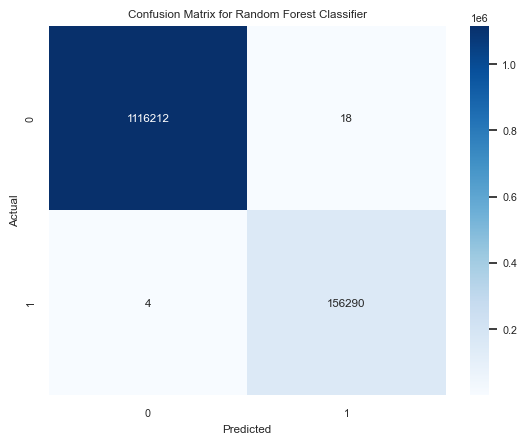

In [23]:
# Plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

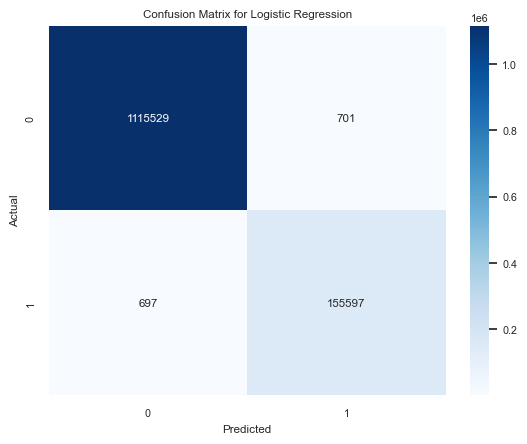

In [24]:
sns.heatmap(confusion_matrix(y_test, y_pred1), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**CONCLUSION FROM EVALUATION**

Its clear from the confusion matrix that random forest is more effective in tracking down fraud cases then logistic regression and in fraud detection model catching more fraud cases is critical so we will proceed with random forest for predicting output as fraud or legitimate. 

**Taking Input and predicting Fraud or Not Fraud**

In [25]:

def predict_transaction(model):
    print("\n Enter transaction details below to predict if it's fraud or not:\n")


    trans_type = input("Transaction type (CASH_IN, CASH_OUT, DEBIT, PAYMENT, TRANSFER): ").strip().upper()
    amount = float(input("Transaction amount: "))
    oldbalanceOrg = float(input("Old balance of sender: "))
    newbalanceOrig = float(input("New balance of sender: "))
    oldbalanceDest = float(input("Old balance of receiver: "))
    newbalanceDest = float(input("New balance of receiver: "))

    # Manual one-hot encoding (assuming CASH_IN is dropped)
    type_CASH_OUT = 1 if trans_type == 'CASH_OUT' else 0
    type_DEBIT = 1 if trans_type == 'DEBIT' else 0
    type_PAYMENT = 1 if trans_type == 'PAYMENT' else 0
    type_TRANSFER = 1 if trans_type == 'TRANSFER' else 0

    # Construct input DataFrame
    input_df = pd.DataFrame([{
        'amount': amount,
        'oldbalanceOrg': oldbalanceOrg,
        'newbalanceOrig': newbalanceOrig,
        'oldbalanceDest': oldbalanceDest,
        'newbalanceDest': newbalanceDest,
        'type_CASH_OUT': type_CASH_OUT,
        'type_DEBIT': type_DEBIT,
        'type_PAYMENT': type_PAYMENT,
        'type_TRANSFER': type_TRANSFER
    }])

    # Feature scaling
    input_df = (input_df - X_train.mean()) / X_train.std()
   

    # Predict
    prediction = model.predict(input_df)[0]
    if prediction == 1:
        print("\n This transaction is predicted to be **FRAUD**.")
    else:
        print("\n This transaction is predicted to be **NOT FRAUD**.")



In [26]:
# predict_transaction(model)

In [27]:
import joblib
joblib.dump(model,'model.pkl')

['model.pkl']

In [28]:
# Save the feature names (important!)
feature_names = X_train.columns.tolist()

joblib.dump((model, feature_names, X_train.mean(), X_train.std()), 'model_bundle.pkl')


['model_bundle.pkl']

In [29]:
# Corrected code for the last cell
test_case = pd.DataFrame([{
    'amount': 1000,
    'oldbalanceOrg': 0,
    'newbalanceOrig': 0,
    'oldbalanceDest': 0,
    'newbalanceDest': 0,
    'type_CASH_OUT': 0,
    'type_DEBIT': 0,
    'type_PAYMENT': 0,
    'type_TRANSFER': 0,
    'type_CASH_IN': 1,
    'is_anomalous': 1
}])

# Calculate errorOrig and errorDest for the test case
test_case['errorOrig'] = test_case['oldbalanceOrg'] - test_case['newbalanceOrig'] - test_case['amount']
test_case['errorDest'] = test_case['newbalanceDest'] - test_case['oldbalanceDest'] - test_case['amount']

# Ensure the test_case columns match the training data
test_case = test_case[X_train.columns]  # Align columns with training data

# Use the scaler object to scale the test case
test_case_scaled = scaler.transform(test_case)

# Predict
prediction = model.predict(test_case_scaled)
print("Prediction for edge case:", "Fraud" if prediction[0] == 1 else "Not Fraud")

Prediction for edge case: Fraud
